In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras.optimizers import Adam
from keras.callbacks import TensorBoard, CSVLogger, ModelCheckpoint
from lipnet.lipreading.generators import BasicGenerator
from lipnet.lipreading.callbacks import Statistics, Visualize
from lipnet.lipreading.curriculums import Curriculum
from lipnet.core.decoders import Decoder
from lipnet.lipreading.helpers import labels_to_text
from lipnet.utils.spell import Spell
from lipnet.model2 import LipNet
import numpy as np
import datetime
import cv2
import skvideo.io
import dlib
from scipy.misc import imresize
from lipnet.lipreading.aligns import Align
import imageio
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
np.random.seed(55)

CURRENT_PATH = 'training/unseen_speakers/'
DATASET_DIR  = os.path.join(CURRENT_PATH, 'datasets')
OUTPUT_DIR   = os.path.join(CURRENT_PATH, 'results')
LOG_DIR      = os.path.join(CURRENT_PATH, 'logs')

PREDICT_GREEDY      = False
PREDICT_BEAM_WIDTH  = 200
PREDICT_DICTIONARY  = os.path.join(CURRENT_PATH,'..','..','common','dictionaries','grid.txt')
FACE_PREDICTOR_PATH  = os.path.join(CURRENT_PATH,'..','..','common','predictors','shape_predictor_68_face_landmarks.dat')

def curriculum_rules(epoch):
    return { 'sentence_length': -1, 'flip_probability': 0.5, 'jitter_probability': 0.05 }

In [3]:
run_name = datetime.datetime.now().strftime('%Y:%m:%d_%H:%M:%S')
start_epoch, stop_epoch, img_c, img_w, img_h, frames_n, absolute_max_string_len, minibatch_size = \
0, 5000, 3,  100, 50, 75, 32, 2


curriculum = Curriculum(curriculum_rules)
lip_gen = BasicGenerator(dataset_path=DATASET_DIR,
                            minibatch_size=minibatch_size,
                            img_c=img_c, img_w=img_w, img_h=img_h, frames_n=frames_n,
                            absolute_max_string_len=absolute_max_string_len,
                            curriculum=curriculum, start_epoch=start_epoch).build()

print('batch gen created...')
lipnet = LipNet(img_c=img_c, img_w=img_w, img_h=img_h, frames_n=frames_n,
                        absolute_max_string_len=absolute_max_string_len, output_size=lip_gen.get_output_size())
#     print(lipnet.summary())


adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
lipnet.model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam)

# load weight if necessary
if start_epoch > 0:
    weight_file = os.path.join(OUTPUT_DIR, os.path.join('weights_grid.h5' % (start_epoch - 1)))
    lipnet.model.load_weights(weight_file)

spell = Spell(path=PREDICT_DICTIONARY)
decoder = Decoder(greedy=PREDICT_GREEDY, beam_width=PREDICT_BEAM_WIDTH,
                  postprocessors=[labels_to_text, spell.sentence])

# define callbacks
# statistics  = Statistics(lipnet, lip_gen.next_val(), decoder, 256, output_dir=os.path.join(OUTPUT_DIR, run_name))
# visualize   = Visualize(os.path.join(OUTPUT_DIR, run_name), lipnet, lip_gen.next_val(), decoder, num_display_sentences=minibatch_size)
tensorboard = TensorBoard(log_dir=os.path.join(LOG_DIR, run_name))
# csv_logger  = CSVLogger(os.path.join(LOG_DIR, "{}-{}.csv".format('training',run_name)), separator=',', append=True)
checkpoint  = ModelCheckpoint(os.path.join(OUTPUT_DIR, "weights_grid.h5"), monitor='val_loss', save_weights_only=True, mode='auto', period=1)

    


Loading dataset list from cache...
Found 6 videos for training.
Found 0 videos for validation.

batch gen created...
y_pred (?, 75, 28)


In [7]:
g = lip_gen.next_train()
x,y = next(g)
print(x['the_input'].shape)
print(x['the_labels'].shape)
print(x['source_str'])
''.join([chr(int(t)+97) for t in x['the_labels'][0] ])

(75, 100, 50, 3)
[15. 11.  0.  2.  4. 26.  6. 17.  4.  4. 13. 26.  0. 19. 26. 19. 26. 18.
  8. 23. 26. 13. 14. 22. -1. -1. -1. -1. -1. -1. -1. -1.]
(75, 100, 50, 3)
[15. 11.  0.  2.  4. 26.  1. 11. 20.  4. 26.  1. 24. 26.  5. 26. 18.  4.
 21.  4. 13. 26.  0.  6.  0.  8. 13. -1. -1. -1. -1. -1.]
(2, 75, 100, 50, 3)
(2, 32)
['place green at t six now' 'place blue by f seven again']


'place{green{at{t{six{now````````'

In [4]:
# g = lip_gen.next_train()
    # x,y = next(g)
    # print(x['the_input'].shape)
    # print(x['the_labels'].shape)
lipnet.model.fit_generator(generator=lip_gen.next_train(),
                    steps_per_epoch=1, epochs=stop_epoch,
#                     validation_data=lip_gen.next_val()
#                     , validation_steps=1,
                    callbacks=[checkpoint, tensorboard], 
                    initial_epoch=start_epoch, 
                    verbose=1
#                                ,
#                         max_q_size=5,
#                         workers=2,
#                         pickle_safe=True
                          )

Epoch 1/5000
Epoch 0: Curriculum(train: True, sentence_length: -1, flip_probability: 0.5, jitter_probability: 0.05)
(75, 100, 50, 3)
[15. 11.  0.  2.  4. 26.  6. 17.  4.  4. 13. 26.  0. 19. 26. 19. 26. 18.
  8. 23. 26. 13. 14. 22. -1. -1. -1. -1. -1. -1. -1. -1.]
(75, 100, 50, 3)
[15. 11.  0.  2.  4. 26.  1. 11. 20.  4. 26.  1. 24. 26.  5. 26. 18.  4.
 21.  4. 13. 26.  0.  6.  0.  8. 13. -1. -1. -1. -1. -1.]
(75, 100, 50, 3)
[ 1.  8. 13. 26. 17.  4.  3. 26.  8. 13. 26.  8. 26.  5.  8. 21.  4. 26.
 18. 14. 14. 13. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
(75, 100, 50, 3)
[ 1.  8. 13. 26. 22.  7.  8. 19.  4. 26.  8. 13. 26.  9. 26. 14. 13.  4.
 26. 18. 14. 14. 13. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
(75, 100, 50, 3)
[11.  0. 24. 26. 22.  7.  8. 19.  4. 26.  0. 19. 26.  7. 26. 13.  8. 13.
  4. 26. 18. 14. 14. 13. -1. -1. -1. -1. -1. -1. -1. -1.]
(75, 100, 50, 3)
[15. 11.  0.  2.  4. 26. 17.  4.  3. 26. 22.  8. 19.  7. 26.  0. 26. 14.
 13.  4. 26. 18. 14. 14. 13. -1. -1. -1. -1. -1. -1. -

KeyboardInterrupt: 

In [5]:
g = lip_gen.next_train()
x,y = next(g)

(75, 100, 50, 3)
[15. 11.  0.  2.  4. 26.  6. 17.  4.  4. 13. 26.  0. 19. 26. 19. 26. 18.
  8. 23. 26. 13. 14. 22. -1. -1. -1. -1. -1. -1. -1. -1.]
(75, 100, 50, 3)
[15. 11.  0.  2.  4. 26.  1. 11. 20.  4. 26.  1. 24. 26.  5. 26. 18.  4.
 21.  4. 13. 26.  0.  6.  0.  8. 13. -1. -1. -1. -1. -1.]


In [8]:
x['the_input'][0].shape

(75, 100, 50, 3)

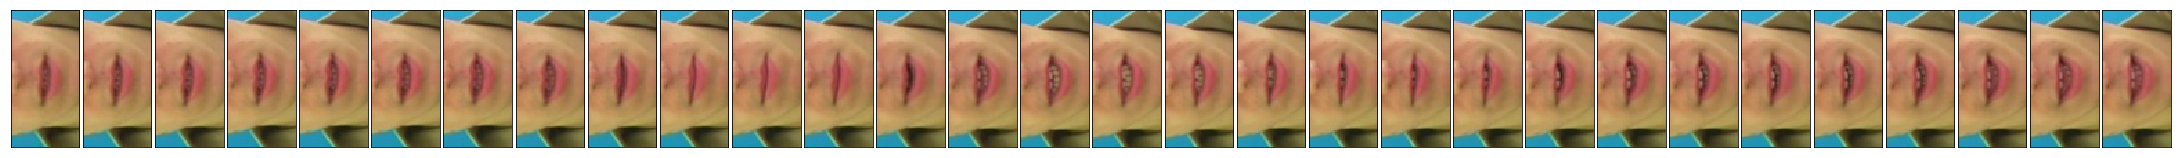

In [11]:
# im = batch_frames[1][25]
import matplotlib.pyplot as plt
%matplotlib inline
# generator = datagen(min_row_number=0,max_row_number=200000, batch_size= 6)
# X,Y = next(generator)
X = x['the_input'][0]
# print(X.shape, Y.shape)
def plot_data(x,ax):
#     x = x.reshape((size,size))
    ax.imshow(x[...,::-1], cmap='gray')
#     if y is not None:
#         ax.scatter(y[0::2] , y[1::2] , marker='x', s=10)
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    plot_data(X[i], ax)